In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.nan)
import cv2
import glob
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from utils import *
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import peak_local_max

In [2]:
cars = glob.glob('./train_test_images/vehicles/**/*.png',recursive=True)
notcars = glob.glob('./train_test_images/non-vehicles/**/*.png',recursive=True)

In [3]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(64, 64), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [4]:
# Reduce the sample size to an equal size
sample_size = 8412
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 14 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
filehandler = open('svc.pickel', 'wb')
pickle.dump(svc, filehandler)

Using: 11 orientations 14 pixels per cell and 2 cells per block
Feature vector length: 4356
11.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9825
My SVC predicts:  [ 0.  1.  0.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  1.  1.  1.  0.  0.]
0.00156 Seconds to predict 10 labels with SVC


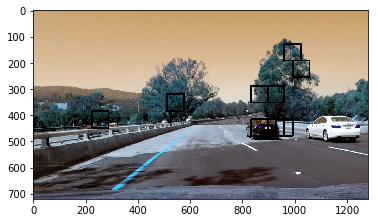

In [5]:
file_pi = open('svc.pickel', 'rb')
svc = pickle.load(file_pi)
y_start_stop = [None, None] # Min and max in y to search in slide_window()

image_raw = cv2.imread('./test_images/test4.jpg')
image = image_raw.astype(np.float32)/255
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

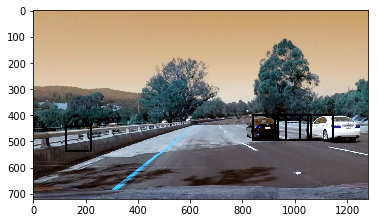

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)           
    return img, bbox
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img, bbox_list = find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

In [28]:
def lucas_flow(frame1,frame2,p0):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # Create some random colors
    color = np.random.randint(0,255,(100,3))
    if  frame2 == [] or p0 == []:
        # Take first frame and find corners in it
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
        p0 = cv2.goodFeaturesToTrack(frame1, mask = None, **feature_params)
        # Create a mask image for drawing purposes
        mask = np.zeros_like(frame1)
    
    else:
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(frame2, frame1, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        plt.imshow(mask)
        plt.imshow(frame)
        plt.show()
        # Now update the previous frame and previous points
        p0 = good_new.reshape(-1,1,2)
        
    frame2 = frame1.copy()
    return p0,frame2

In [29]:
def dense_flow(frame1,nextframe):
    prvs = cv2.cvtColor(frame1,cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255
    if nextframe != []:
        next = cv2.cvtColor(nextframe,cv2.COLOR_RGB2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 6, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        hsv = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return hsv

In [83]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

image_raw = cv2.imread('./test_images/test4.jpg')
draw_image = np.copy(image_raw)
image = image_raw.astype(np.float32)/255
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def heat_threshold(heatmap,threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def bboxes_estimation(img, labels,speedmap,max_var,max_ang,min_samples):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        speed_list = []
        ang_list = []
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Check Optical flow for those pixels
        ########
        if speedmap != []:
            speed = speedmap[nonzero[0],nonzero[1],2]
            ang = speedmap[nonzero[0],nonzero[1],0]
            
            print("Number of Elements")
            print(len(speed))
            
            print("Var Speed Value")
            speed_var = np.var(speed)
            print(speed_var)
            
            print("Var Direction Value")
            ang_var = np.var(ang)
            print(ang_var)
            
            ang_sum = np.sum(ang)
            print("Sum Direction Value")
            print(ang_sum)

            print("----")
        if (speed_var != 0 or ang_var != 0) and ang_var < max_var and len(speed)>min_samples:#and ang_sum < max_ang:
        # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

speedmap = []
heat_his = []
frame2 = []
frame3 = []
frame4 = []


In [94]:
speedmap = []
heat_his = []
frame2 = []
frame3 = []
frame4 = []

def pipe_detect(image_raw):
    speed = False
    global frame2,frame3,frame4
    global heat_his
    speedmap = dense_flow(image_raw,frame2)
    image = image_raw.astype(np.float32)/255
    draw_img = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    ystart = 400
    ystop = 656
    scale = 1.5
    threshold = 2
    max_heat_his = 15 
    max_var = 200
    max_ang = 200000
    min_samples = 1153
    time_weight = 0.2
    heat_w = np.copy(heat)
    out_img, bbox_list = find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #TODO
    # Integrate final heatmap from previous image into the new heatmap
    heat = add_heat(heat,bbox_list)
    
    # Apply threshold to help remove false positives
    if heat_his != [] and 'bbox_box' in locals():
        heat_his.append(heat)
        len_l = len(heat_his)
        if len(heat_his) < max_heat_his:
            for i in range(len_l):
                heat_w = cv2.addWeighted(heat_w, 1, heat_his[i], i/len_l, 0)
        else:
            for i in range(len_l):
                heat_w = cv2.addWeighted(heat_w, 1, heat_his[i], i/len_l, 0)
            heat_his.pop(0)

        # Visualize the heatmap when displaying  
        heat = heat_threshold(heat_w,threshold*(len(heat_his)*time_weight))
        heatmap = np.clip(heat, 0, 255)
        
    elif 'bbox_box' in locals():
        heat_his.append(heat)
        # Visualize the heatmap when displaying    
        heat = heat_threshold(heat,threshold)
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = bboxes_estimation(np.copy(image_raw), labels,speedmap,max_var,max_ang,min_samples)
        fig = plt.figure()
        plt.subplot(221)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(223)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        if frame2 != []:
            plt.subplot(122)
            plt.imshow(speedmap)
            plt.title('Speed Map')
        fig.tight_layout()
        plt.show()

    frame4 = frame3
    frame3 = frame2
    frame2 = image_raw
    return draw_img

pipe_detect(image_raw)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
speedmap = []
heat_his = []
frame2 = []
frame3 = []
frame4 = []
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("./project_video.mp4")
# Look at the critical part
#clip1 = clip1.subclip(30, 50)
white_clip = clip1.fl_image(pipe_detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
del white_clip

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



  4%|▍         | 56/1261 [00:38<13:55,  1.44it/s]